# London House Price Predict

## 0. Prepare

Import modules.

In [25]:
import pandas as pd
import numpy as np
import scipy
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn import mixture
from sklearn import svm
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

Load data.

In [26]:
hp=pd.read_csv("D:/python_l7/London_cleaned_20201208_2.csv")

## 1. Class for predict

In [27]:
class pricePredictor():
    
    def __init__(self,data,responseCol=0,preditorColStart=1,preditorColEnd=68):
        self.data=data
        self.responseCol=responseCol
        self.preditorColStart=preditorColStart
        self.preditorColEnd=preditorColEnd
            
    def perfectVariable(self,xTrain,xTest,
                        scalerOrNot=True,
                        pcaOrNot=True):
        # Convert X to avoid missingvalue and then scaler,PCA
        # C means converter
        # missing value
        impC = SimpleImputer()   
        impC.fit(xTrain)
        xTrain = impC.transform(xTrain)
        xTest = impC.transform(xTest)
        # scaler
        if scalerOrNot:
            scalerC = preprocessing.StandardScaler()
            scalerC.fit(xTrain)
            xTrain = scalerC.transform(xTrain)
            xTest = scalerC.transform(xTest)
        if pcaOrNot:
            pcaC = PCA(0.95)
            pcaC.fit(xTrain,xTest)
            xTrain = pcaC.transform(xTrain)
            xTest = pcaC.transform(xTest)
        rs={
            "xTrainConverted":xTrain,
            "xTestConverted":xTest
            }
        return(rs)        
    
    def segementSet(self,testRatio=0.2,bootstrap=True,bootstrapMultiple=5,
                    scalerOrNot=True,pcaOrNot=True,newData=False,dtN=None):
        ixAll=np.array(np.array(range(self.data.shape[0])))
        testCount=int(self.data.shape[0]*testRatio)
        testIx=np.random.choice(ixAll,
                                testCount,
                                replace=False)
        if bootstrap:
            trainIx=np.random.choice(ixAll[~np.isin(ixAll,testIx)],
                                     (self.data.shape[0]-testCount)*bootstrapMultiple,
                                     replace=True)
        else:
            trainIx=ixAll[~np.isin(ixAll,testIx)]
        if newData:
            xA=self.data.iloc[:,self.preditorColStart:self.preditorColEnd].values
            yA=self.data.iloc[:,self.responseCol].values
            xE=dtN.iloc[:,self.preditorColStart:self.preditorColEnd].values
            yE=dtN.iloc[:,self.responseCol].values
        else:
            xA=self.data.iloc[trainIx,self.preditorColStart:self.preditorColEnd].values
            yA=self.data.iloc[trainIx,self.responseCol].values
            xE=self.data.iloc[testIx,self.preditorColStart:self.preditorColEnd].values
            yE=self.data.iloc[testIx,self.responseCol].values
            # convert X for train and X for test
        variableConverted=self.perfectVariable(xA,xE,
                                               scalerOrNot=scalerOrNot,
                                               pcaOrNot=pcaOrNot)
        xA=variableConverted['xTrainConverted']
        xE=variableConverted['xTestConverted']
        # result
        aeSet={
            "xA":xA,
            "yA":yA,
            "xE":xE,
            "yE":yE
            }
        return(aeSet)
    
    def getMAPE(self,prediction,actual):
        prediction=np.array(prediction)
        actual=np.array(actual)
        MAPE=np.mean(np.abs(prediction - actual)/np.abs(actual))
        return(MAPE)
    
    def fitMod(self,method,
               testRatio=0.2,bootstrap=True,
               bootstrapMultiple=5,
               B=10,plot=True,
               scalerOrNot=True,pcaOrNot=True):
        MAPEList=np.array([])
        MAEList=np.array([])
        RMSEList=np.array([])
        for i in range(B):
            aeSet=self.segementSet(testRatio=testRatio,
                                   bootstrap=bootstrap,
                                   bootstrapMultiple=bootstrapMultiple,
                                   scalerOrNot=scalerOrNot,
                                   pcaOrNot=pcaOrNot)
            if method=="LinearRegression":
                mod=LinearRegression()
            elif method=="DecisionTreeRegressor":
                mod=DecisionTreeRegressor()
            elif method=="DecisionTreeRegressor":
                mod=DecisionTreeRegressor()
            elif method=="RandomForestRegressor":
                mod=RandomForestRegressor()
            elif method=="SVR":
                mod=SVR()
            elif method=="Bayes":
                mod=BayesianRidge()
            # fit model
            mod.fit(aeSet['xA'],aeSet['yA'])
            # predict
            prd=mod.predict(aeSet['xE'])
            # calculate MAE and RMSE
            MAPE=self.getMAPE(aeSet['yE'],prd)
            MAE=mean_absolute_error(aeSet['yE'],prd)
            RMSE=mean_squared_error(aeSet['yE'],prd, squared=False)
            # record metrics for each loop
            MAPEList=np.append(MAPEList,MAPE)
            MAEList=np.append(MAEList,MAE)
            RMSEList=np.append(RMSEList,RMSE)
        if plot:
            print(method)
            plt.figure()
            figMAPE=sns.kdeplot(MAPEList).set(title=('MAPE of '+method),
                                              xlim=(0, 1.5))
            plt.show()
            plt.figure()
            figMAE=sns.kdeplot(MAEList).set(title=('MAE of '+method))
            plt.show()
            plt.figure()
            figRMSE=sns.kdeplot(RMSEList).set(title=('RMSE of '+method))
            plt.show()
            print("Mean of MAPE of ",method," is ",str(np.mean(MAPEList)))
            print("Variance of MAPE of ",method," is ",str(np.var(MAPEList)))
            print("Mean of MAE of ",method," is ",str(np.mean(MAEList)))
            print("Variance of MAE of ",method," is ",str(np.var(MAEList)))
            print("Mean of RMSE of ",method," is ",str(np.mean(RMSEList)))
            print("Variance of RMSE of ",method," is ",str(np.var(RMSEList)))
            return(np.mean(MAEList))
        else:
            print(method)
            print("Mean of MAPE of ",method," is ",str(np.mean(MAPEList)))
            print("Variance of MAPE of ",method," is ",str(np.var(MAPEList)))
            print("Mean of MAE of ",method," is ",str(np.mean(MAEList)))
            print("Variance of MAE of ",method," is ",str(np.var(MAEList)))
            print("Mean of RMSE of ",method," is ",str(np.mean(RMSEList)))
            print("Variance of RMSE of ",method," is ",str(np.var(RMSEList)))
            return(np.mean(MAEList))
        
    def forecastNew(self,method,newFileName,
               testRatio=0.05,bootstrap=True,
               bootstrapMultiple=5,
               scalerOrNot=True,pcaOrNot=True):
        dtN=pd.read_csv(newFileName)
        aeSet=self.segementSet(testRatio=testRatio,
                               bootstrap=bootstrap,
                               bootstrapMultiple=bootstrapMultiple,
                               scalerOrNot=scalerOrNot,
                               pcaOrNot=pcaOrNot,
                               newData=True,dtN=dtN)
        if method=="LinearRegression":
            mod=LinearRegression()
        elif method=="DecisionTreeRegressor":
            mod=DecisionTreeRegressor()
        elif method=="DecisionTreeRegressor":
            mod=DecisionTreeRegressor()
        elif method=="RandomForestRegressor":
            mod=RandomForestRegressor()
        elif method=="SVR":
            mod=SVR()
        elif method=="Bayes":
            mod=BayesianRidge()
        # fit model
        mod.fit(aeSet['xA'],aeSet['yA'])
        # predict
        prd=mod.predict(aeSet['xE'])
        # calculate MAE and RMSE
        MAPE=self.getMAPE(aeSet['yE'],prd)
        MAE=mean_absolute_error(aeSet['yE'],prd)
        RMSE=mean_squared_error(aeSet['yE'],prd, squared=False)
        print("MAPE is ",str(MAPE))
        print("MAE is ",str(MAE))
        print("RMSE is ",str(RMSE))
        return(prd)

## 3. Model Compare

### 3.1 Model without Scale/PCA and without bootstrap

Method list.

In [28]:
methodList=["LinearRegression", 
            "DecisionTreeRegressor", 
            "RandomForestRegressor",
            "SVR",
            "Bayes"]

Loop for each model.  

LinearRegression
LinearRegression


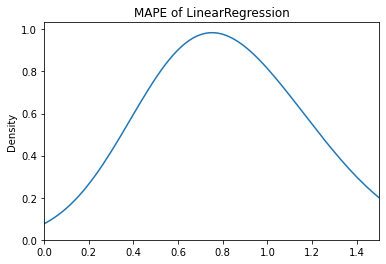

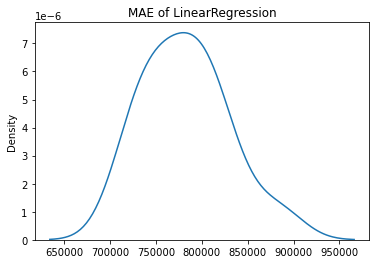

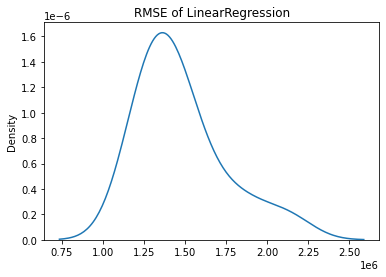

Mean of MAPE of  LinearRegression  is  0.9234835409318717
Variance of MAPE of  LinearRegression  is  0.22788454447445972
Mean of MAE of  LinearRegression  is  782311.8710959384
Variance of MAE of  LinearRegression  is  1992338162.034555
Mean of RMSE of  LinearRegression  is  1476433.5813219405
Variance of RMSE of  LinearRegression  is  64709154574.205734
DecisionTreeRegressor
DecisionTreeRegressor


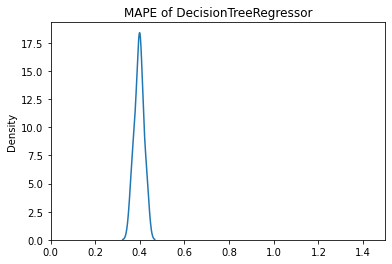

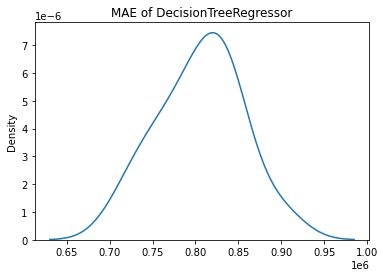

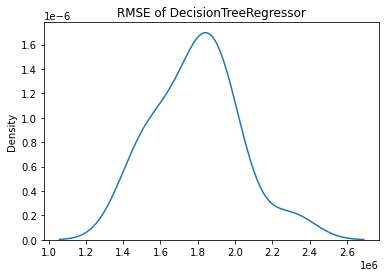

Mean of MAPE of  DecisionTreeRegressor  is  0.3965838363700995
Variance of MAPE of  DecisionTreeRegressor  is  0.00038610549864573384
Mean of MAE of  DecisionTreeRegressor  is  805261.0372525542
Variance of MAE of  DecisionTreeRegressor  is  2203797130.416732
Mean of RMSE of  DecisionTreeRegressor  is  1793221.4776906741
Variance of RMSE of  DecisionTreeRegressor  is  46166116566.196884
RandomForestRegressor
RandomForestRegressor


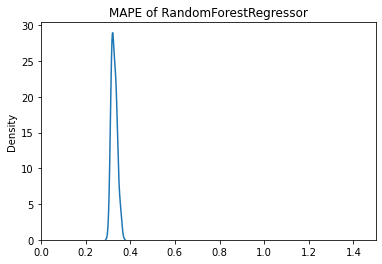

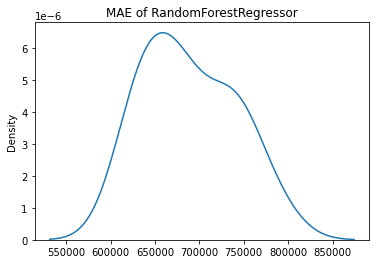

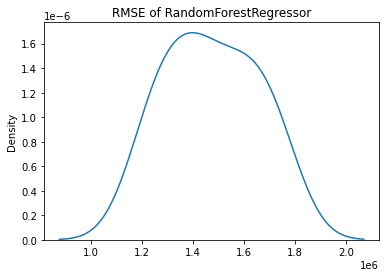

Mean of MAPE of  RandomForestRegressor  is  0.3282952702865027
Variance of MAPE of  RandomForestRegressor  is  0.00013790193788702033
Mean of MAE of  RandomForestRegressor  is  688927.1113576711
Variance of MAE of  RandomForestRegressor  is  2435944747.48344
Mean of RMSE of  RandomForestRegressor  is  1472890.6817221453
Variance of RMSE of  RandomForestRegressor  is  30261978590.628822
SVR
SVR


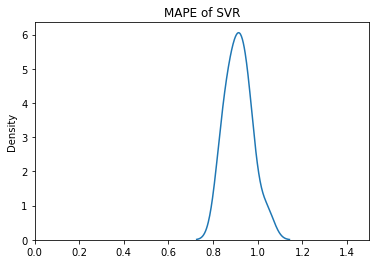

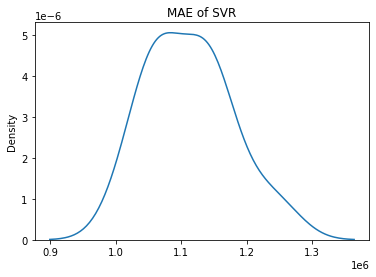

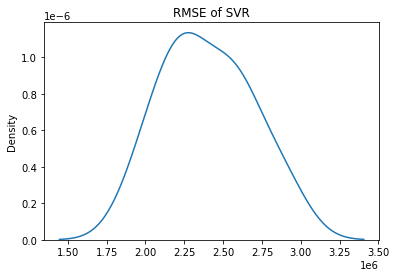

Mean of MAPE of  SVR  is  0.9142082514699058
Variance of MAPE of  SVR  is  0.0030858734087615106
Mean of MAE of  SVR  is  1112039.2118341592
Variance of MAE of  SVR  is  3923086018.804195
Mean of RMSE of  SVR  is  2397223.2578150067
Variance of RMSE of  SVR  is  76296396697.6317
Bayes
Bayes


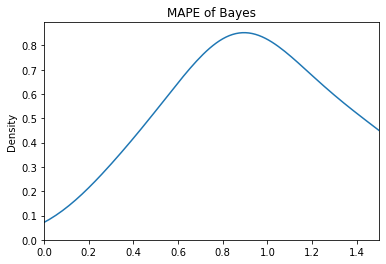

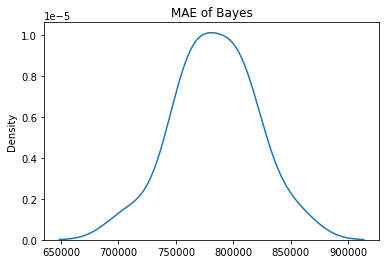

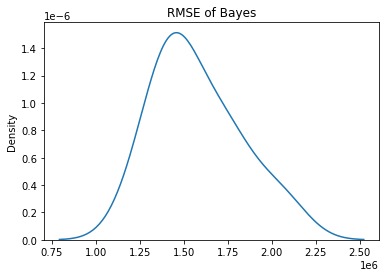

Mean of MAPE of  Bayes  is  1.000329010434424
Variance of MAPE of  Bayes  is  0.1627889364338878
Mean of MAE of  Bayes  is  783645.4372923278
Variance of MAE of  Bayes  is  1124902153.2444792
Mean of RMSE of  Bayes  is  1577269.6342386708
Variance of RMSE of  Bayes  is  56711542386.4407


In [29]:
pp=pricePredictor(hp)
for method in methodList:
    print(method)
    pp.fitMod(method=method,
               B=15,
               bootstrap=False,
               scalerOrNot=False,
               pcaOrNot=False)

### 3.2 Model with Scale/PCA and without bootstrap

LinearRegression
LinearRegression


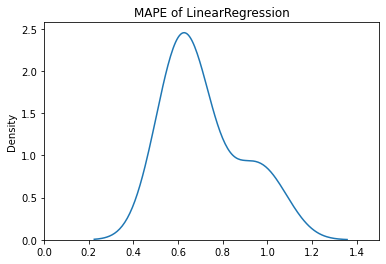

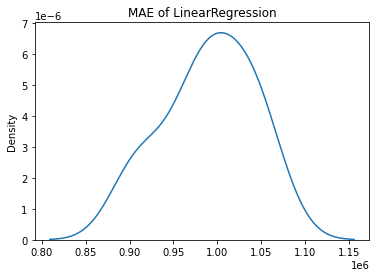

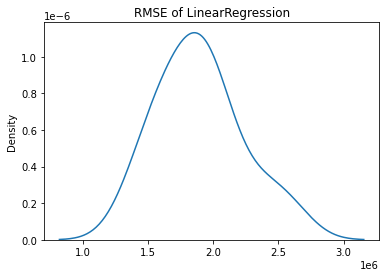

Mean of MAPE of  LinearRegression  is  0.7150705650611483
Variance of MAPE of  LinearRegression  is  0.026836514486220285
Mean of MAE of  LinearRegression  is  990407.41826459
Variance of MAE of  LinearRegression  is  2443013905.5584507
Mean of RMSE of  LinearRegression  is  1894891.5184928712
Variance of RMSE of  LinearRegression  is  99359624487.95076
DecisionTreeRegressor
DecisionTreeRegressor


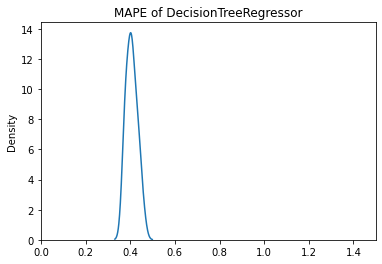

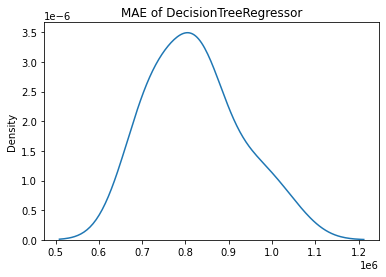

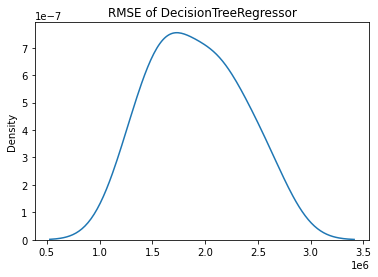

Mean of MAPE of  DecisionTreeRegressor  is  0.40682578314281254
Variance of MAPE of  DecisionTreeRegressor  is  0.0005616365195764865
Mean of MAE of  DecisionTreeRegressor  is  821461.7669380588
Variance of MAE of  DecisionTreeRegressor  is  9663858837.658617
Mean of RMSE of  DecisionTreeRegressor  is  1907753.2600113638
Variance of RMSE of  DecisionTreeRegressor  is  166863768714.27542
RandomForestRegressor
RandomForestRegressor


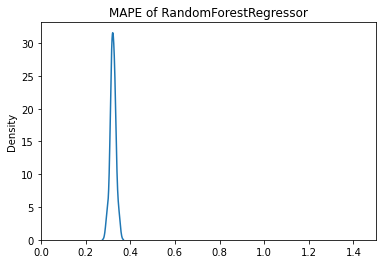

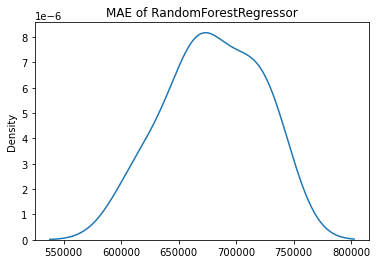

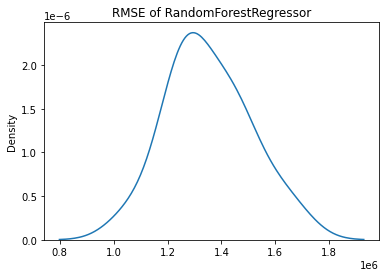

Mean of MAPE of  RandomForestRegressor  is  0.32294066691455386
Variance of MAPE of  RandomForestRegressor  is  0.00013359354690093867
Mean of MAE of  RandomForestRegressor  is  679665.4939373645
Variance of MAE of  RandomForestRegressor  is  1455819207.0305018
Mean of RMSE of  RandomForestRegressor  is  1351853.2195697625
Variance of RMSE of  RandomForestRegressor  is  21863094879.97426
SVR
SVR


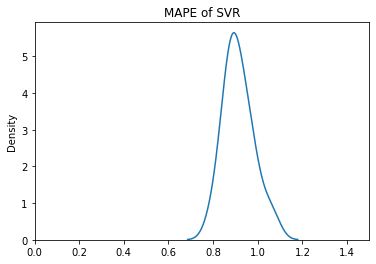

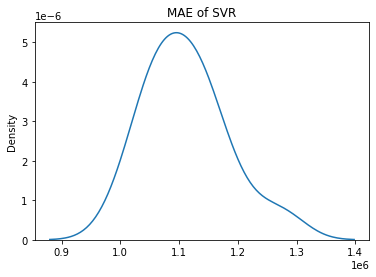

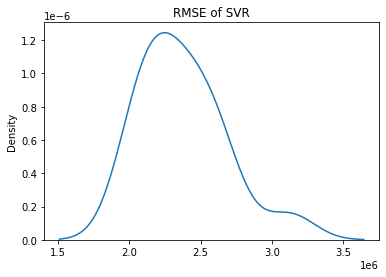

Mean of MAPE of  SVR  is  0.9135939302114325
Variance of MAPE of  SVR  is  0.004141069955028211
Mean of MAE of  SVR  is  1111194.2736569291
Variance of MAE of  SVR  is  4602977871.656424
Mean of RMSE of  SVR  is  2372940.5301372563
Variance of RMSE of  SVR  is  82417272061.80615
Bayes
Bayes


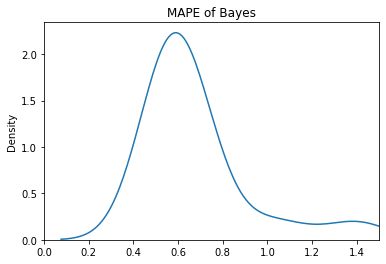

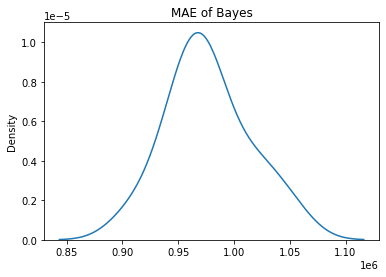

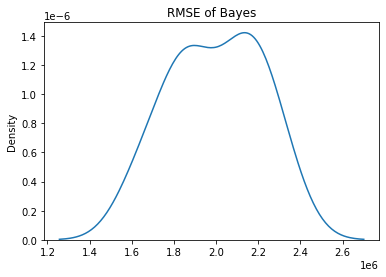

Mean of MAPE of  Bayes  is  0.678108260493704
Variance of MAPE of  Bayes  is  0.05326251012465825
Mean of MAE of  Bayes  is  976823.8280783285
Variance of MAE of  Bayes  is  1284756239.170645
Mean of RMSE of  Bayes  is  1996686.9643935156
Variance of RMSE of  Bayes  is  43619373209.27706


In [30]:
pp=pricePredictor(hp)
for method in methodList:
    print(method)
    pp.fitMod(method=method,
               B=15,
               bootstrap=False,
               scalerOrNot=True,
               pcaOrNot=True)

### 3.3 Model without Scale/PCA and with bootstrap

LinearRegression
LinearRegression


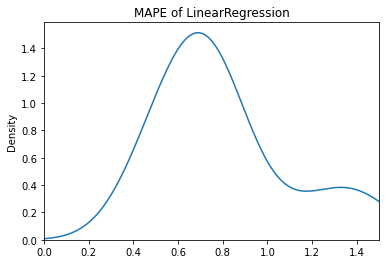

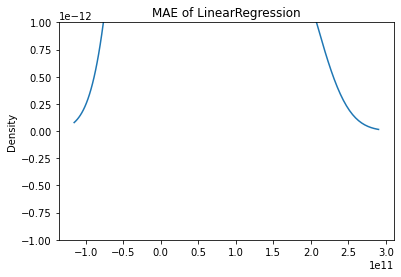

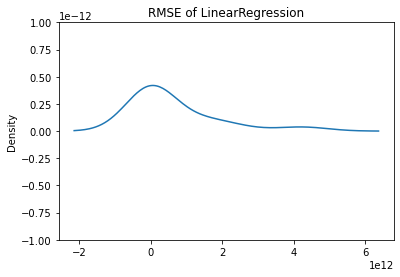

Mean of MAPE of  LinearRegression  is  0.8004954994989865
Variance of MAPE of  LinearRegression  is  0.08081015244030357
Mean of MAE of  LinearRegression  is  38007074219.65636
Variance of MAE of  LinearRegression  is  4.083597031061992e+21
Mean of RMSE of  LinearRegression  is  641086190754.154
Variance of RMSE of  LinearRegression  is  1.409218154434249e+24
DecisionTreeRegressor
DecisionTreeRegressor


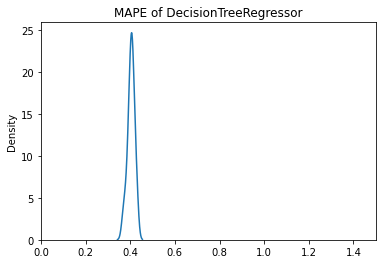

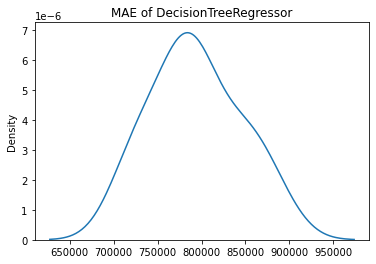

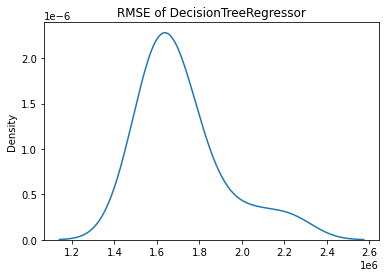

Mean of MAPE of  DecisionTreeRegressor  is  0.40405296153736325
Variance of MAPE of  DecisionTreeRegressor  is  0.00022297854324232312
Mean of MAE of  DecisionTreeRegressor  is  793523.5884528864
Variance of MAE of  DecisionTreeRegressor  is  2384637702.6405444
Mean of RMSE of  DecisionTreeRegressor  is  1715325.4869289515
Variance of RMSE of  DecisionTreeRegressor  is  36420628785.64739
RandomForestRegressor
RandomForestRegressor


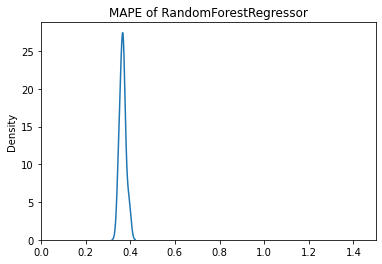

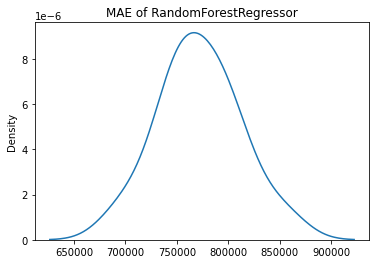

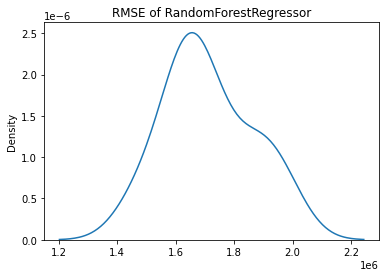

Mean of MAPE of  RandomForestRegressor  is  0.3667658701249776
Variance of MAPE of  RandomForestRegressor  is  0.00018003713884818552
Mean of MAE of  RandomForestRegressor  is  771668.8353420581
Variance of MAE of  RandomForestRegressor  is  1455253664.2544405
Mean of RMSE of  RandomForestRegressor  is  1712510.7141954994
Variance of RMSE of  RandomForestRegressor  is  20795383356.128372
SVR
SVR


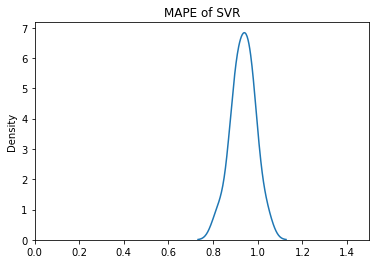

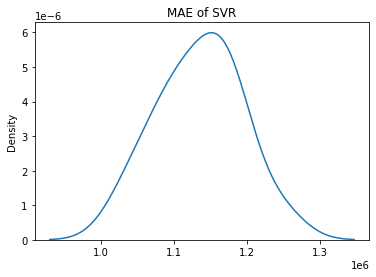

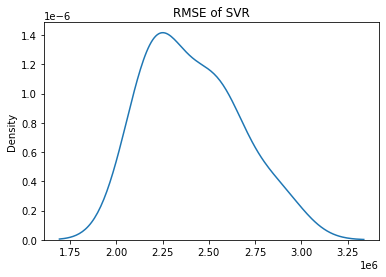

Mean of MAPE of  SVR  is  0.9343818997447015
Variance of MAPE of  SVR  is  0.0025390602881860285
Mean of MAE of  SVR  is  1134441.994560179
Variance of MAE of  SVR  is  3092177935.368117
Mean of RMSE of  SVR  is  2410835.3008840587
Variance of RMSE of  SVR  is  55481053324.99319
Bayes
Bayes


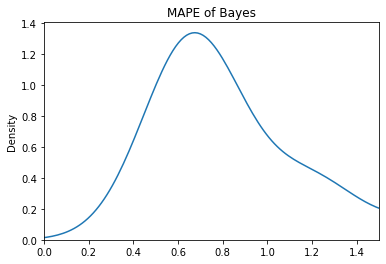

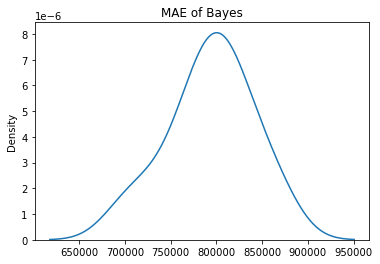

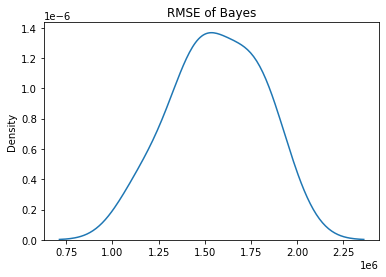

Mean of MAPE of  Bayes  is  0.8431755665444884
Variance of MAPE of  Bayes  is  0.1081446385269685
Mean of MAE of  Bayes  is  793604.3766505615
Variance of MAE of  Bayes  is  1995436994.143573
Mean of RMSE of  Bayes  is  1565401.4768599218
Variance of RMSE of  Bayes  is  51857856609.088844


In [31]:
pp=pricePredictor(hp)
for method in methodList:
    print(method)
    pp.fitMod(method=method,
               B=15,
               bootstrap=True,
               scalerOrNot=False,
               pcaOrNot=False)

### 3.4 Model with Scale/PCA and with bootstrap

LinearRegression
LinearRegression


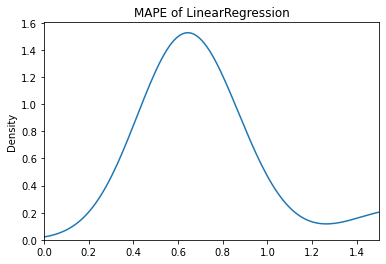

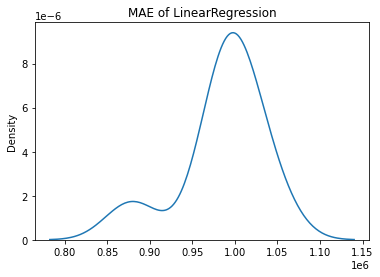

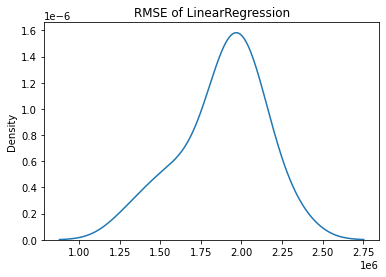

Mean of MAPE of  LinearRegression  is  0.7790950565643868
Variance of MAPE of  LinearRegression  is  0.11644334693275017
Mean of MAE of  LinearRegression  is  985744.6125921347
Variance of MAE of  LinearRegression  is  2239921326.4735794
Mean of RMSE of  LinearRegression  is  1882791.0451614815
Variance of RMSE of  LinearRegression  is  60773131115.58278
DecisionTreeRegressor
DecisionTreeRegressor


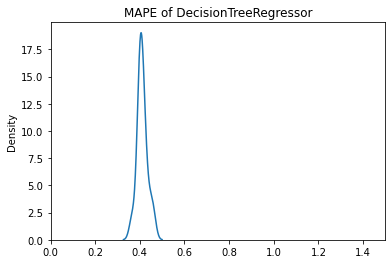

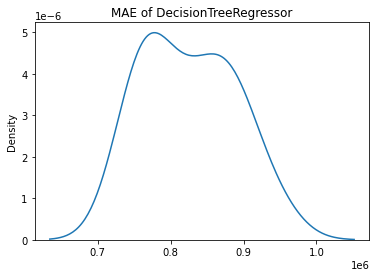

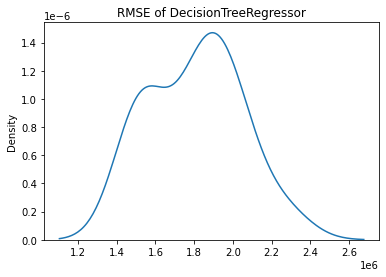

Mean of MAPE of  DecisionTreeRegressor  is  0.41081707341094
Variance of MAPE of  DecisionTreeRegressor  is  0.0004724394527579904
Mean of MAE of  DecisionTreeRegressor  is  825398.1493813888
Variance of MAE of  DecisionTreeRegressor  is  3667166167.465617
Mean of RMSE of  DecisionTreeRegressor  is  1805410.1429667887
Variance of RMSE of  DecisionTreeRegressor  is  51177079717.61298
RandomForestRegressor
RandomForestRegressor


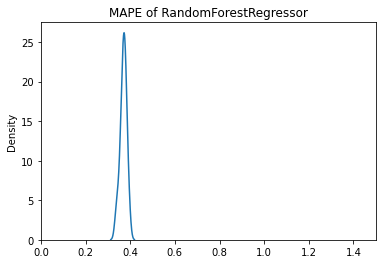

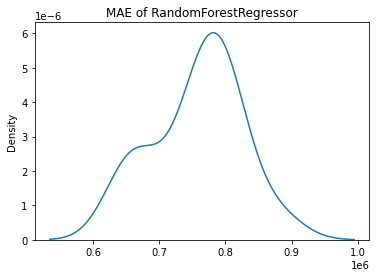

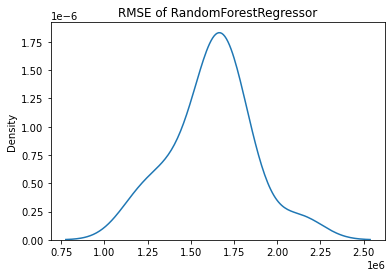

Mean of MAPE of  RandomForestRegressor  is  0.3695958340459697
Variance of MAPE of  RandomForestRegressor  is  0.0001920706682542995
Mean of MAE of  RandomForestRegressor  is  757480.9583804682
Variance of MAE of  RandomForestRegressor  is  4053380291.3819814
Mean of RMSE of  RandomForestRegressor  is  1622455.7992640666
Variance of RMSE of  RandomForestRegressor  is  50072377918.27038
SVR
SVR


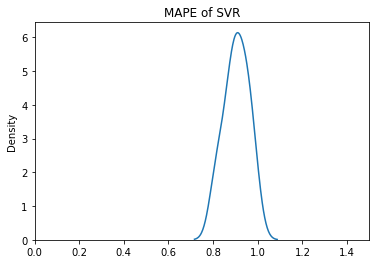

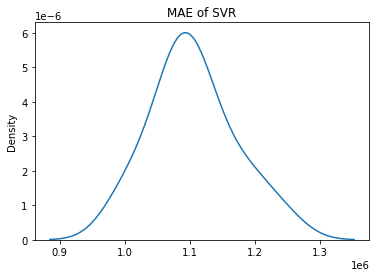

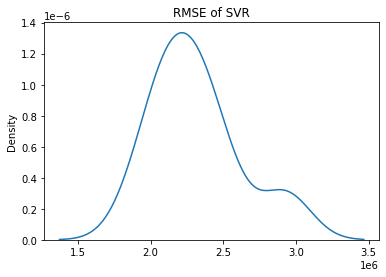

Mean of MAPE of  SVR  is  0.9044240214641847
Variance of MAPE of  SVR  is  0.0027593978896216734
Mean of MAE of  SVR  is  1104611.2216540715
Variance of MAE of  SVR  is  3864932102.5674887
Mean of RMSE of  SVR  is  2312083.7622962566
Variance of RMSE of  SVR  is  84953338901.23528
Bayes
Bayes


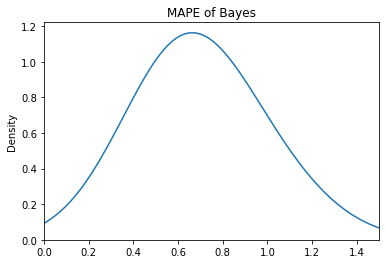

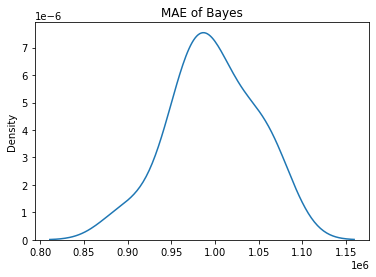

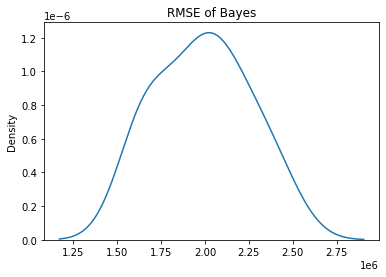

Mean of MAPE of  Bayes  is  0.8148091939050583
Variance of MAPE of  Bayes  is  0.20994649040265506
Mean of MAE of  Bayes  is  997229.5760761437
Variance of MAE of  Bayes  is  2165106164.8207116
Mean of RMSE of  Bayes  is  1988592.3646593944
Variance of RMSE of  Bayes  is  64370656089.81191


In [32]:
pp=pricePredictor(hp)
for method in methodList:
    print(method)
    pp.fitMod(method=method,
               B=15,
               bootstrap=True,
               scalerOrNot=True,
               pcaOrNot=True)

### 3.5 Conclusion of Compare

In 5 models above, random forest also perform best with lowest MAPE, MAE and RMSE.  
Scale and PCA is useful.  
Models with bootstrap perform almost no different with models without bootstrap.  

## 5. Predict for New Data

Use new csv file name as arguement.

In [33]:
newFileName="D:/python_17/London_new_20201208.csv"

In [34]:
pp=pricePredictor(hp)
prd=pp.forecastNew("RandomForestRegressor",
                   newFileName)

MAPE is  0.07696698409453849
MAE is  77350.00535113038
RMSE is  93569.95768795846


Show prediction.

In [35]:
print(prd)

[1842283.33333333  774931.84163059  687440.37619048 1697270.83333333
  631055.43333333  407348.5       ]


Show actual.

In [36]:
dtN=pd.read_csv(newFileName)

In [37]:
print(dtN.price)

0    1675000
1     650000
2     735000
3    1765000
4     675000
5     420000
Name: price, dtype: int64
